In [16]:
import numpy as np
import pandas as pd
import os
import sys

# Add the directory containing the VotingModel to the Python path
sys.path.append(os.path.abspath('/Users/idrees/Code/govxs/'))
from model.VotingRules import mean_aggregation, median_aggregation, quadratic_aggregation
from model.VotingModel import VotingModel

def random_change_vote(vote, num_projects):
    """Randomly change a single vote."""
    new_vote = vote.copy()
    change_idx = np.random.randint(0, num_projects)
    new_vote[change_idx] = np.random.uniform(0, 1)
    return new_vote

def calculate_distance(x, x_prime):
    """Calculate the distance between two outcomes using L1 distance."""
    return np.sum(np.abs(x - x_prime))

def evaluate_robustness(model, rounds):
    robustness_results = {
        "mean_distances": [],
        "median_distances": [],
        "quadratic_distances": []
    }
    for method in ["mean", "median", "quadratic"]:
        
        for _ in range(rounds):
            # Step 1: Take the original vote profile and compute the outcome
            original_outcome = model.allocate_funds(method)

            # Step 2: Randomly change the vote of a single voter
            voter_idx = np.random.randint(0, model.num_voters)
            original_vote = model.voting_matrix[voter_idx].copy()
            new_vote = random_change_vote(original_vote, model.num_projects)
            new_voting_matrix = model.voting_matrix.copy()
            new_voting_matrix[voter_idx] = new_vote

            # Update the model's voting matrix
            model.voting_matrix = new_voting_matrix

            # Step 3: Compute the new outcome
            new_outcome = model.allocate_funds(method)

            # Step 4: Calculate the distance between the original and new outcomes
            distance = calculate_distance(original_outcome, new_outcome)

            # Append the distance to the appropriate list
            if method == "mean":
                robustness_results["mean_distances"].append(distance)
            elif method == "median":
                robustness_results["median_distances"].append(distance)
            elif method == "quadratic":
                robustness_results["quadratic_distances"].append(distance)

            # Reset the voting matrix to the original
            model.voting_matrix[voter_idx] = original_vote

    # Convert the results dictionary to a DataFrame
    robustness_df = pd.DataFrame(robustness_results)

    # Add a column for the iteration index
    robustness_df["round"] = robustness_df.index + 1

    


    return robustness_df

# Initialize the model
num_voters = 144
num_projects = 600
total_op_tokens = 30e6
rounds = 1000
voter_type = 'random_uniform_model'
model = VotingModel(voter_type=voter_type, num_voters=num_voters, num_projects=num_projects, total_op_tokens=total_op_tokens)
model.step()

# Evaluate robustness
robustness_results = evaluate_robustness(model, rounds)

robustness_results


/Users/idrees/Code/govxs/agents/VoterAgent.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


,mean_distances,median_distances,quadratic_distances,round
0,206.611787,425.735611,767.212263,1
1,1060.046276,1311.271142,752.878108,2
2,335.432874,912.071862,483.989861,3
3,719.422237,0.000000,238.026336,4
4,175.467977,0.000000,533.268279,5
...,...,...,...,...
995,753.018722,1182.667069,331.201634,996
996,368.374257,0.000000,379.402528,997
997,272.158839,1980.971086,239.843525,998
998,12.222976,0.000000,193.280928,999


In [18]:
print(f"Avg Mean L1 Distance: {np.mean(robustness_results['mean_distances'])}")
print(f"Avg Median L1 Distance: {np.mean(robustness_results['median_distances'])}")
print(f"Avg Quadratic L1 Distance: {np.mean(robustness_results['quadratic_distances'])}")

Avg Mean L1 Distance: 346.7585709176922
Avg Median L1 Distance: 493.19599495105274
Avg Quadratic L1 Distance: 349.71181187172994


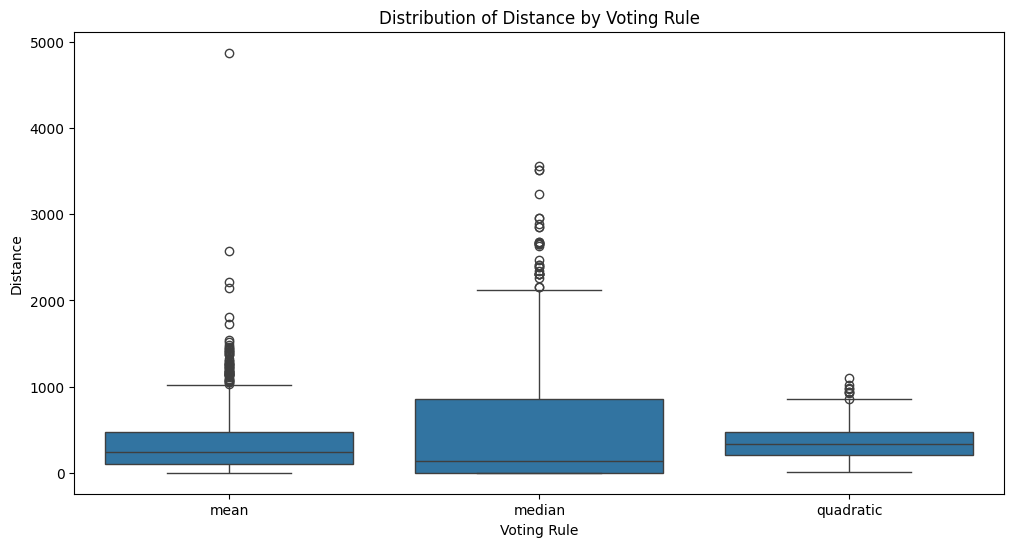

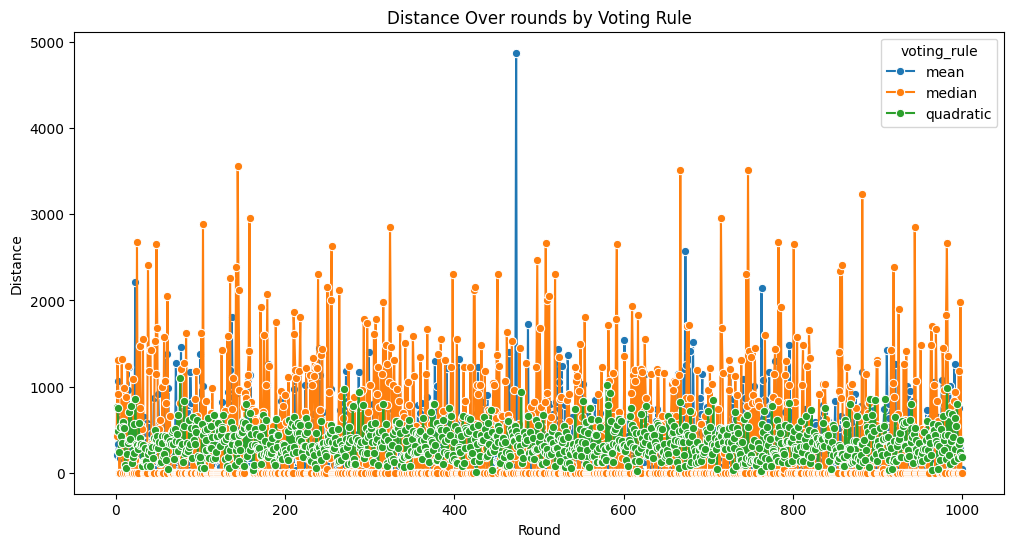

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
robustness_results_long = robustness_results.melt(id_vars=['round'], var_name='voting_rule', value_name='distance')
robustness_results_long['voting_rule'] = robustness_results_long['voting_rule'].str.replace('_distances', '')

# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='voting_rule', y='distance', data=robustness_results_long)
plt.title('Distribution of Distance by Voting Rule')
plt.xlabel('Voting Rule')
plt.ylabel('Distance')
plt.show()

# Line Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='round', y='distance', hue='voting_rule', data=robustness_results_long, marker='o')
plt.title('Distance Over rounds by Voting Rule')
plt.xlabel('Round')
plt.ylabel('Distance')
plt.show()
